In [1]:
# Импортируем необходимые библиотеки

from dotenv import load_dotenv
from sqlalchemy.engine import URL
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Подтянем данные для подключения к БД

load_dotenv()

True

In [3]:
con = os.environ.get("POSG_ENG")

In [4]:
# Посмотрим на таблицу с признаками пользователей

user_data = pd.read_sql(
    """SELECT * FROM "user_data" """,
    con=con
)

user_data

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads
...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic
163201,168549,0,18,Russia,Tula,2,Android,organic
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic
163203,168551,0,38,Russia,Moscow,3,iOS,organic


In [5]:
# Посмотрим на таблицу признаков постов

post_text_df = pd.read_sql(
    """SELECT * FROM "post_text_df" """,
    con=con
)

post_text_df

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business
...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie
7019,7316,I give this movie 2 stars purely because of it...,movie
7020,7317,I cant believe this film was allowed to be mad...,movie
7021,7318,The version I saw of this film was the Blockbu...,movie


In [6]:
# Загрузим таблицу взаимодействий пользователей с постами
# Таблица очень большая, поэтому загрузим 10 млн записей, причем только с action == view,
# так как like'и нам неинтересны

feed_data = pd.read_sql(
    """
    SELECT timestamp, user_id, post_id, target FROM "feed_data"
    WHERE action = 'view'
    LIMIT 10000000
    """,
    con=con
)

feed_data

,timestamp,user_id,post_id,target
0,2021-12-19 10:23:26,150762,1987,1
1,2021-12-19 10:26:20,150762,1413,1
2,2021-12-19 10:28:25,150762,2964,0
3,2021-12-23 16:36:43,150762,5522,0
4,2021-12-23 16:39:22,150762,2243,0
...,...,...,...,...
9999995,2021-12-20 16:35:31,23397,6472,1
9999996,2021-12-20 16:36:25,23397,1759,0
9999997,2021-12-20 16:37:49,23397,3490,0
9999998,2021-12-20 16:40:42,23397,2694,0


In [7]:
# Переведем timestamp в datetime и выделим новые признаки

feed_data['timestamp'] = pd.to_datetime(feed_data['timestamp'])

feed_data['day_of_week'] = feed_data["timestamp"].dt.dayofweek
feed_data['hour'] = feed_data["timestamp"].dt.hour
feed_data['month'] = feed_data["timestamp"].dt.month

# теперь timestamp можно удалить

feed_data = feed_data.drop("timestamp", axis=1)

feed_data

,user_id,post_id,target,day_of_week,hour,month
0,150762,1987,1,6,10,12
1,150762,1413,1,6,10,12
2,150762,2964,0,6,10,12
3,150762,5522,0,3,16,12
4,150762,2243,0,3,16,12
...,...,...,...,...,...,...
9999995,23397,6472,1,0,16,12
9999996,23397,1759,0,0,16,12
9999997,23397,3490,0,0,16,12
9999998,23397,2694,0,0,16,12


In [8]:
# Приступим к обработке текстов постов

to_tf_idf = post_text_df["text"].copy()
to_tf_idf

0       UK economy facing major risks\n\nThe UK manufa...
1       Aids and climate top Davos agenda\n\nClimate c...
2       Asian quake hits European shares\n\nShares in ...
3       India power shares jump on debut\n\nShares in ...
4       Lacroix label bought by US firm\n\nLuxury good...
                              ...                        
7018    OK, I would not normally watch a Farrelly brot...
7019    I give this movie 2 stars purely because of it...
7020    I cant believe this film was allowed to be mad...
7021    The version I saw of this film was the Blockbu...
7022    Piece of subtle art. Maybe a masterpiece. Doub...
Name: text, Length: 7023, dtype: object

In [9]:
# Попробуем выделить новые признаки на основе заголовка поста

import re

def extract_first_sentence(text):
    # Оставим текст до первого переноса
    first_paragraph = text.split('\n')[0]
    
    # Используем регулярное выражение для поиска первого предложения
    sentence_match = re.match(r'^.*?[.!?]', first_paragraph)
    
    # Если нашли символ конца предложения, то берем его
    if sentence_match:
        first_sentence = sentence_match.group()
        return first_sentence.strip()
    else:
        # Если не нашли - оставляем первые 100 символов
        return first_paragraph[:100].strip()

In [10]:
for i in range(len(to_tf_idf)):
    to_tf_idf[i] = extract_first_sentence(to_tf_idf[i]).lower()

to_tf_idf

0                           uk economy facing major risks
1                       aids and climate top davos agenda
2                        asian quake hits european shares
3                        india power shares jump on debut
4                         lacroix label bought by us firm
                              ...                        
7018    ok, i would not normally watch a farrelly brot...
7019    i give this movie 2 stars purely because of it...
7020     i cant believe this film was allowed to be made.
7021    the version i saw of this film was the blockbu...
7022                                 piece of subtle art.
Name: text, Length: 7023, dtype: object

In [11]:
# Применим tf-idf к заголовкам

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

tfidf_vectorized = TfidfVectorizer(stop_words='english').fit_transform(to_tf_idf)
df_tfidf = pd.DataFrame(tfidf_vectorized.todense())

In [12]:
# Понизим пространство tf-idf при помощи TSNE и присоединим к таблице с признаками постов

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=1)
tsne_df = tsne.fit_transform(df_tfidf)

tsne_df = pd.DataFrame(tsne_df, columns=['first_sent_Tsne_1st_component', 
                                         'first_sent_Tsne_2nd_component'])

tsne_df

,first_sent_Tsne_1st_component,first_sent_Tsne_2nd_component
0,-1.114951,-0.401547
1,-1.462065,-1.214896
2,0.099942,1.910774
3,-0.314240,2.019531
4,-3.996821,-1.597468
...,...,...
7018,-3.218006,-0.484462
7019,0.228527,0.565862
7020,-0.644639,-3.561190
7021,0.846265,-0.640479


In [13]:
post_text_df = pd.concat([post_text_df, tsne_df], axis=1)

In [14]:
# Проделаем все то же самое уже для каждого текста полностью

tfidf_vectorized = TfidfVectorizer(stop_words='english').fit_transform(post_text_df["text"])
df_tfidf = pd.DataFrame(tfidf_vectorized.todense())

In [15]:
tsne = TSNE(n_components=2, random_state=1)
tsne_df_2 = tsne.fit_transform(df_tfidf)

tsne_df_2 = pd.DataFrame(tsne_df_2, columns=['stop_Tsne_1st_component', 
                                             'stop_sent_Tsne_2nd_component'])

tsne_df_2

,stop_Tsne_1st_component,stop_sent_Tsne_2nd_component
0,-62.223442,5.328465
1,-44.850658,17.338881
2,-55.391346,10.538198
3,-64.975166,18.223566
4,-73.163002,19.095057
...,...,...
7018,34.637787,18.332684
7019,54.542511,-3.147404
7020,40.958065,-23.341749
7021,26.420452,-33.771481


In [16]:
post_text_df = pd.concat([post_text_df, tsne_df_2], axis=1)

In [17]:
# Выделим ещё пару признаков

post_text_df['tf_idf_stop_max'] = df_tfidf.max()
post_text_df['tf_idf_stop_mean'] = df_tfidf.mean()

post_text_df.head()

,post_id,text,topic,first_sent_Tsne_1st_component,first_sent_Tsne_2nd_component,stop_Tsne_1st_component,stop_sent_Tsne_2nd_component,tf_idf_stop_max,tf_idf_stop_mean
0,1,UK economy facing major risks\n\nThe UK manufa...,business,-1.114951,-0.401547,-62.223442,5.328465,0.462776,0.000495
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,-1.462065,-1.214896,-44.850658,17.338881,0.452829,0.004566
2,3,Asian quake hits European shares\n\nShares in ...,business,0.099942,1.910774,-55.391346,10.538198,0.064370,0.000009
3,4,India power shares jump on debut\n\nShares in ...,business,-0.314240,2.019531,-64.975166,18.223566,0.104535,0.000015
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,-3.996821,-1.597468,-73.163002,19.095057,0.324894,0.000385


In [18]:
# Теперь кластеризуем посты и найдём расстояния до каждого центра имеющихся кластеров

import string
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download("wordnet")
wnl = nltk.stem.WordNetLemmatizer()

def preprocessing(line, token=wnl):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    line = line.replace('\n\n', ' ').replace('\n', ' ')
    line = ' '.join([token.lemmatize(x) for x in line.split(' ')])
    return line


tfidf = TfidfVectorizer(
    stop_words='english',
    preprocessor=preprocessing
)

tfidf

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\masli\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


TfidfVectorizer(preprocessor=<function preprocessing at 0x0000010BF770BF40>,
                stop_words='english')

In [19]:
tfidf_data = (
    tfidf
    .fit_transform(post_text_df['text'])
    .toarray()
)

tfidf_data = pd.DataFrame(
    tfidf_data,
    index=post_text_df.post_id,
    columns=tfidf.get_feature_names_out()
)

### Генерим фичи на основе TfIdf

post_text_df['TotalTfIdf'] = tfidf_data.sum(axis=1).reset_index()[0]
post_text_df['MaxTfIdf'] = tfidf_data.max(axis=1).reset_index()[0]
post_text_df['MeanTfIdf'] = tfidf_data.mean(axis=1).reset_index()[0]

### Пытаемся кластеризовать тексты

from sklearn.decomposition import PCA

centered = tfidf_data - tfidf_data.mean()

pca = PCA(n_components=20)
pca_decomp = pca.fit_transform(centered)

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(pca_decomp)

post_text_df['TextCluster'] = kmeans.labels_

dists_columns = ['DistanceTo1stCluster',
                 'DistanceTo2ndCluster',
                 'DistanceTo3rdCluster',
                 'DistanceTo4thCluster',
                 'DistanceTo5thCluster',
                 'DistanceTo6thCluster',
                 'DistanceTo7thCluster',
                 'DistanceTo8thCluster',
                 'DistanceTo9thCluster',
                 'DistanceTo10thCluster',
                 'DistanceTo11thCluster',
                 'DistanceTo12thCluster',
                 'DistanceTo13thCluster',
                 'DistanceTo14thCluster',
                 'DistanceTo15thCluster']

dists_df = pd.DataFrame(
    data=kmeans.transform(pca_decomp),
    columns=dists_columns
)

dists_df.head()

,DistanceTo1stCluster,DistanceTo2ndCluster,DistanceTo3rdCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,0.450452,0.438186,0.438452,0.531316,0.466875,0.391394,0.152884,0.481270,0.436808,0.507024,0.444317,0.498383,0.547989,0.527751,0.463824
1,0.286011,0.294401,0.302251,0.286624,0.346575,0.174747,0.262055,0.351486,0.288273,0.387358,0.293710,0.422857,0.458006,0.415348,0.334685
2,0.328541,0.310793,0.314888,0.481028,0.349573,0.233782,0.120191,0.366144,0.324445,0.396278,0.325685,0.424071,0.484561,0.432061,0.354455
3,0.281431,0.258861,0.257472,0.432625,0.310219,0.145190,0.220219,0.325204,0.270672,0.359974,0.282274,0.404617,0.449429,0.386593,0.293769
4,0.199286,0.169935,0.162333,0.394371,0.249509,0.107510,0.282552,0.264810,0.230500,0.303881,0.219741,0.346562,0.408368,0.342436,0.233024


In [20]:
post_text_df = pd.concat((post_text_df, dists_df), axis=1)

post_text_df.head()

,post_id,text,topic,first_sent_Tsne_1st_component,first_sent_Tsne_2nd_component,stop_Tsne_1st_component,stop_sent_Tsne_2nd_component,tf_idf_stop_max,tf_idf_stop_mean,TotalTfIdf,...,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,1,UK economy facing major risks\n\nThe UK manufa...,business,-1.114951,-0.401547,-62.223442,5.328465,0.462776,0.000495,8.748129,...,0.391394,0.152884,0.481270,0.436808,0.507024,0.444317,0.498383,0.547989,0.527751,0.463824
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,-1.462065,-1.214896,-44.850658,17.338881,0.452829,0.004566,11.878472,...,0.174747,0.262055,0.351486,0.288273,0.387358,0.293710,0.422857,0.458006,0.415348,0.334685
2,3,Asian quake hits European shares\n\nShares in ...,business,0.099942,1.910774,-55.391346,10.538198,0.064370,0.000009,12.675530,...,0.233782,0.120191,0.366144,0.324445,0.396278,0.325685,0.424071,0.484561,0.432061,0.354455
3,4,India power shares jump on debut\n\nShares in ...,business,-0.314240,2.019531,-64.975166,18.223566,0.104535,0.000015,6.622786,...,0.145190,0.220219,0.325204,0.270672,0.359974,0.282274,0.404617,0.449429,0.386593,0.293769
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,-3.996821,-1.597468,-73.163002,19.095057,0.324894,0.000385,6.352096,...,0.107510,0.282552,0.264810,0.230500,0.303881,0.219741,0.346562,0.408368,0.342436,0.233024


In [21]:
# Обработаем тексты постов моделью DistilBert

import torch
from transformers import DistilBertTokenizer, DistilBertModel
import pandas as pd

# Посмотрим доступность GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device, torch.cuda.get_device_name())

Using device: cuda NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [22]:
# Загрузим модель и токенизатор DistilBERT на GPU
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [23]:
# Напишем функцию для получения эмбеддингов текста на GPU
def get_text_embeddings(text):
    # Токенизируем текст и преобразуйте в тензор на GPU
    input_ids = tokenizer.encode(text, return_tensors='pt', max_length=512, truncation=True, padding=True).to(device)

    # Получаем эмбеддинги от модели на GPU
    with torch.no_grad():
        outputs = model(input_ids)

    # Вернём эмбеддинги для всего текста на CPU
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

In [24]:
import numpy as np

post_text_df['embeddings'] = post_text_df['text'].apply(get_text_embeddings)

embeddings_array = np.vstack(post_text_df['embeddings'].to_numpy())

In [25]:
# Понизим пространство столбца с эмбеддингами до 3-х

from sklearn.decomposition import PCA

centered = embeddings_array - embeddings_array.mean()

pca = PCA(n_components=3)
pca_decomp = pca.fit_transform(centered)

In [26]:
for i in range(pca_decomp.shape[1]):
    post_text_df[f'embedding_{i + 1}'] = pca_decomp[:, i]

post_text_df = post_text_df.drop(['text', 'embeddings'], axis=1)

post_text_df

,post_id,topic,first_sent_Tsne_1st_component,first_sent_Tsne_2nd_component,stop_Tsne_1st_component,stop_sent_Tsne_2nd_component,tf_idf_stop_max,tf_idf_stop_mean,TotalTfIdf,MaxTfIdf,...,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster,embedding_1,embedding_2,embedding_3
0,1,business,-1.114951,-0.401547,-62.223442,5.328465,0.462776,0.000495,8.748129,0.495805,...,0.436808,0.507024,0.444317,0.498383,0.547989,0.527751,0.463824,-0.782234,-2.211454,-0.205918
1,2,business,-1.462065,-1.214896,-44.850658,17.338881,0.452829,0.004566,11.878472,0.308003,...,0.288273,0.387358,0.293710,0.422857,0.458006,0.415348,0.334685,-0.670262,-1.993638,-0.072129
2,3,business,0.099942,1.910774,-55.391346,10.538198,0.064370,0.000009,12.675530,0.261799,...,0.324445,0.396278,0.325685,0.424071,0.484561,0.432061,0.354455,-0.641463,-1.735065,-0.448665
3,4,business,-0.314240,2.019531,-64.975166,18.223566,0.104535,0.000015,6.622786,0.537713,...,0.270672,0.359974,0.282274,0.404617,0.449429,0.386593,0.293769,-0.321566,-1.744855,-0.555608
4,5,business,-3.996821,-1.597468,-73.163002,19.095057,0.324894,0.000385,6.352096,0.420251,...,0.230500,0.303881,0.219741,0.346562,0.408368,0.342436,0.233024,-0.645754,-1.341985,-0.605657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,7315,movie,-3.218006,-0.484462,34.637787,18.332684,0.158955,0.000110,6.703302,0.258412,...,0.391613,0.136915,0.345163,0.449829,0.497432,0.445875,0.373822,-1.192415,1.312016,0.698859
7019,7316,movie,0.228527,0.565862,54.542511,-3.147404,0.063389,0.000009,6.471377,0.399419,...,0.338009,0.082174,0.325101,0.413246,0.438993,0.410401,0.323670,-0.999022,1.237878,0.928334
7020,7317,movie,-0.644639,-3.561190,40.958065,-23.341749,0.161935,0.000023,5.628524,0.573061,...,0.319488,0.287676,0.274122,0.399080,0.403933,0.374840,0.280627,-0.732478,1.445920,0.655156
7021,7318,movie,0.846265,-0.640479,26.420452,-33.771481,0.296780,0.000262,6.883375,0.231244,...,0.338852,0.299355,0.298017,0.400722,0.365305,0.410481,0.325778,-1.589977,1.253510,-0.387443


In [30]:
# Сохраним таблицу в базу данных

# post_text_df.to_sql('a_maslennikov_post_features_lesson_22', con=con, if_exists='replace')

In [ ]:
# Очистим память, стерев всё ненужное

In [27]:
%whos

Variable                 Type                   Data/Info
---------------------------------------------------------
DistilBertModel          type                   <class 'transformers.mode<...>tilbert.DistilBertModel'>
DistilBertTokenizer      type                   <class 'transformers.mode<...>ert.DistilBertTokenizer'>
KMeans                   ABCMeta                <class 'sklearn.cluster._kmeans.KMeans'>
PCA                      ABCMeta                <class 'sklearn.decomposition._pca.PCA'>
TSNE                     type                   <class 'sklearn.manifold._t_sne.TSNE'>
TfidfTransformer         type                   <class 'sklearn.feature_e<...>n.text.TfidfTransformer'>
TfidfVectorizer          type                   <class 'sklearn.feature_e<...>on.text.TfidfVectorizer'>
URL                      type                   <class 'sqlalchemy.engine.url.URL'>
centered                 ndarray                7023x768: 5393664 elems, type `float32`, 21574656 bytes (20.5751953125 

In [28]:
del centered
del df_tfidf
del dists_df
del embeddings_array
del pca_decomp
del tfidf_data
del to_tf_idf
del tsne_df
del tsne_df_2

#### Можно приступать к обучению модели

In [29]:
# Соберем все имеющиеся таблицы в один датафрейм

df = user_data.merge(feed_data, left_on=["user_id"], right_on=["user_id"])
df = df.merge(post_text_df, left_on=["post_id"], right_on=["post_id"])
df = df.set_index(["user_id", "post_id"])
df

,,gender,age,country,city,exp_group,os,source,target,day_of_week,hour,...,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster,embedding_1,embedding_2,embedding_3
user_id,post_id,,,,,,,,,,,,,,,,,,,,,
9145,6988,0,18,Russia,Saint Petersburg,3,iOS,ads,0,4,10,...,0.349254,0.201533,0.285121,0.389517,0.439190,0.434452,0.349234,-1.002350,1.171769,1.121434
9156,6988,0,39,Russia,Linda,1,Android,ads,0,6,21,...,0.349254,0.201533,0.285121,0.389517,0.439190,0.434452,0.349234,-1.002350,1.171769,1.121434
9163,6988,1,26,Russia,Moscow,3,Android,ads,1,6,20,...,0.349254,0.201533,0.285121,0.389517,0.439190,0.434452,0.349234,-1.002350,1.171769,1.121434
9172,6988,0,38,Russia,Kineshma,1,Android,ads,0,3,19,...,0.349254,0.201533,0.285121,0.389517,0.439190,0.434452,0.349234,-1.002350,1.171769,1.121434
9179,6988,0,19,Russia,Krasnotur’insk,4,iOS,ads,0,3,9,...,0.349254,0.201533,0.285121,0.389517,0.439190,0.434452,0.349234,-1.002350,1.171769,1.121434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165323,7246,1,21,Russia,Mytishchi,1,Android,organic,0,0,21,...,0.296519,0.248037,0.239947,0.371126,0.423077,0.355649,0.251182,-0.525081,1.499282,-0.578311
165325,7246,1,15,Russia,Zheleznogorsk,0,iOS,organic,0,4,13,...,0.296519,0.248037,0.239947,0.371126,0.423077,0.355649,0.251182,-0.525081,1.499282,-0.578311
165366,7246,1,36,Russia,Ivangorod,0,Android,organic,0,5,21,...,0.296519,0.248037,0.239947,0.371126,0.423077,0.355649,0.251182,-0.525081,1.499282,-0.578311


In [30]:
df.columns

Index(['gender', 'age', 'country', 'city', 'exp_group', 'os', 'source',
       'target', 'day_of_week', 'hour', 'month', 'topic',
       'first_sent_Tsne_1st_component', 'first_sent_Tsne_2nd_component',
       'stop_Tsne_1st_component', 'stop_sent_Tsne_2nd_component',
       'tf_idf_stop_max', 'tf_idf_stop_mean', 'TotalTfIdf', 'MaxTfIdf',
       'MeanTfIdf', 'TextCluster', 'DistanceTo1stCluster',
       'DistanceTo2ndCluster', 'DistanceTo3rdCluster', 'DistanceTo4thCluster',
       'DistanceTo5thCluster', 'DistanceTo6thCluster', 'DistanceTo7thCluster',
       'DistanceTo8thCluster', 'DistanceTo9thCluster', 'DistanceTo10thCluster',
       'DistanceTo11thCluster', 'DistanceTo12thCluster',
       'DistanceTo13thCluster', 'DistanceTo14thCluster',
       'DistanceTo15thCluster', 'embedding_1', 'embedding_2', 'embedding_3'],
      dtype='object')

In [31]:
# Можно удалить исходные таблицы

del user_data
del feed_data
del post_text_df

In [32]:
# Поделим датафрейм на трейн и тест 4 к 1

X_train, X_test = df.iloc[:-2000000].drop("target", axis=1), df.iloc[-2000000:].drop("target", axis=1)

y_train, y_test = df["target"].iloc[:-2000000], df["target"].iloc[-2000000:]

In [33]:
# Определим категориальные столбцы

cat_cols = [
    'topic', 'TextCluster', 'gender', 'country',
    'city', 'exp_group', 'hour', 'month',
    'os', 'source'
]

#### Будем обучать CatBoostClassifier, а для оптимизации используем optuna
###### В качестве прокси метрики используется roc-auc. Будем его максимизировать

In [42]:
import optuna

from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 700, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 5e-2, 1, log=True),
        "depth": trial.suggest_int("depth", 1, 10)
    }

    model = CatBoostClassifier(**params, random_state=42, cat_features=cat_cols, silent=True)
    model.fit(X_train, y_train)
    predictions = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, predictions)
    return roc_auc

In [43]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2023-12-21 13:11:26,407] A new study created in memory with name: no-name-d5a4020d-050e-4cdd-9e52-ac6bb846525e
[I 2023-12-21 13:12:14,566] Trial 0 finished with value: 0.6613253095281566 and parameters: {'iterations': 143, 'learning_rate': 0.05934434977999521, 'depth': 4}. Best is trial 0 with value: 0.6613253095281566.
[I 2023-12-21 13:13:13,919] Trial 1 finished with value: 0.6736340184769705 and parameters: {'iterations': 143, 'learning_rate': 0.13199600804190062, 'depth': 5}. Best is trial 1 with value: 0.6736340184769705.
[I 2023-12-21 13:14:00,609] Trial 2 finished with value: 0.6710100259656346 and parameters: {'iterations': 100, 'learning_rate': 0.18481265765732793, 'depth': 4}. Best is trial 1 with value: 0.6736340184769705.
[I 2023-12-21 13:15:33,967] Trial 3 finished with value: 0.6859966390701812 and parameters: {'iterations': 140, 'learning_rate': 0.20218363882003645, 'depth': 8}. Best is trial 3 with value: 0.6859966390701812.
[I 2023-12-21 13:16:48,270] Trial 4 finish

In [44]:
print('Best hyperparameters:', study.best_params)
print('Best roc_auc:', study.best_value)

Best hyperparameters: {'iterations': 376, 'learning_rate': 0.2750435261977789, 'depth': 7}
Best roc_auc: 0.6977550814854928


In [45]:
# Нашли лучшие параметры, а теперь посмотрим на качество на трейне и тесте

model = CatBoostClassifier(random_state=42, cat_features=cat_cols, **study.best_params)

In [46]:
model.fit(X_train, y_train)

0:	learn: 0.5175264	total: 1.12s	remaining: 7m
1:	learn: 0.4379072	total: 1.36s	remaining: 4m 14s
2:	learn: 0.3942665	total: 2.59s	remaining: 5m 21s
3:	learn: 0.3738803	total: 3.62s	remaining: 5m 36s
4:	learn: 0.3634796	total: 4.79s	remaining: 5m 55s
5:	learn: 0.3582350	total: 5.89s	remaining: 6m 3s
6:	learn: 0.3555083	total: 7.02s	remaining: 6m 9s
7:	learn: 0.3527375	total: 8.18s	remaining: 6m 16s
8:	learn: 0.3516296	total: 9.28s	remaining: 6m 18s
9:	learn: 0.3502014	total: 10.4s	remaining: 6m 19s
10:	learn: 0.3497832	total: 11.4s	remaining: 6m 18s
11:	learn: 0.3492924	total: 12.1s	remaining: 6m 7s
12:	learn: 0.3489975	total: 12.9s	remaining: 5m 59s
13:	learn: 0.3487842	total: 14s	remaining: 6m 1s
14:	learn: 0.3478649	total: 15.1s	remaining: 6m 3s
15:	learn: 0.3474112	total: 16.4s	remaining: 6m 8s
16:	learn: 0.3472732	total: 17.5s	remaining: 6m 9s
17:	learn: 0.3467842	total: 18.7s	remaining: 6m 12s
18:	learn: 0.3466810	total: 19.7s	remaining: 6m 10s
19:	learn: 0.3464161	total: 21s	rem

157:	learn: 0.3383028	total: 3m 16s	remaining: 4m 30s
158:	learn: 0.3382853	total: 3m 17s	remaining: 4m 29s
159:	learn: 0.3381835	total: 3m 18s	remaining: 4m 28s
160:	learn: 0.3381698	total: 3m 19s	remaining: 4m 26s
161:	learn: 0.3381529	total: 3m 21s	remaining: 4m 25s
162:	learn: 0.3381127	total: 3m 22s	remaining: 4m 24s
163:	learn: 0.3381061	total: 3m 23s	remaining: 4m 22s
164:	learn: 0.3380893	total: 3m 24s	remaining: 4m 21s
165:	learn: 0.3380705	total: 3m 25s	remaining: 4m 20s
166:	learn: 0.3380425	total: 3m 27s	remaining: 4m 19s
167:	learn: 0.3379773	total: 3m 28s	remaining: 4m 18s
168:	learn: 0.3379724	total: 3m 29s	remaining: 4m 16s
169:	learn: 0.3379538	total: 3m 30s	remaining: 4m 15s
170:	learn: 0.3379447	total: 3m 31s	remaining: 4m 14s
171:	learn: 0.3379181	total: 3m 33s	remaining: 4m 12s
172:	learn: 0.3378702	total: 3m 34s	remaining: 4m 11s
173:	learn: 0.3378577	total: 3m 35s	remaining: 4m 10s
174:	learn: 0.3378028	total: 3m 36s	remaining: 4m 8s
175:	learn: 0.3377836	total: 

310:	learn: 0.3342692	total: 6m 8s	remaining: 1m 17s
311:	learn: 0.3342482	total: 6m 9s	remaining: 1m 15s
312:	learn: 0.3342247	total: 6m 10s	remaining: 1m 14s
313:	learn: 0.3342063	total: 6m 11s	remaining: 1m 13s
314:	learn: 0.3341837	total: 6m 13s	remaining: 1m 12s
315:	learn: 0.3341729	total: 6m 14s	remaining: 1m 11s
316:	learn: 0.3341509	total: 6m 15s	remaining: 1m 9s
317:	learn: 0.3341389	total: 6m 16s	remaining: 1m 8s
318:	learn: 0.3341018	total: 6m 17s	remaining: 1m 7s
319:	learn: 0.3340394	total: 6m 18s	remaining: 1m 6s
320:	learn: 0.3339997	total: 6m 19s	remaining: 1m 5s
321:	learn: 0.3339714	total: 6m 20s	remaining: 1m 3s
322:	learn: 0.3339381	total: 6m 22s	remaining: 1m 2s
323:	learn: 0.3339027	total: 6m 23s	remaining: 1m 1s
324:	learn: 0.3338908	total: 6m 24s	remaining: 1m
325:	learn: 0.3338682	total: 6m 25s	remaining: 59.1s
326:	learn: 0.3338485	total: 6m 26s	remaining: 57.9s
327:	learn: 0.3338110	total: 6m 27s	remaining: 56.7s
328:	learn: 0.3337580	total: 6m 28s	remaining

In [47]:
roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]), roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

(0.7259321771889853, 0.6977550814854928)

In [48]:
# Удалим лишнее и обучим модель на всех данных

del X_train
del X_test
del y_train
del y_test

In [49]:
X = df.drop("target", axis=1)
y = df["target"]

In [50]:
del df

In [52]:
model = CatBoostClassifier(random_state=42, cat_features=cat_cols, **study.best_params)

In [53]:
model.fit(X, y)

0:	learn: 0.5193180	total: 1.3s	remaining: 8m 8s
1:	learn: 0.4372242	total: 2.64s	remaining: 8m 13s
2:	learn: 0.3975817	total: 4s	remaining: 8m 17s
3:	learn: 0.3740097	total: 5.45s	remaining: 8m 27s
4:	learn: 0.3632680	total: 6.46s	remaining: 7m 59s
5:	learn: 0.3581590	total: 7.52s	remaining: 7m 43s
6:	learn: 0.3558847	total: 8.08s	remaining: 7m 5s
7:	learn: 0.3536169	total: 9.49s	remaining: 7m 16s
8:	learn: 0.3525155	total: 10.9s	remaining: 7m 23s
9:	learn: 0.3506145	total: 12.3s	remaining: 7m 30s
10:	learn: 0.3499513	total: 13.5s	remaining: 7m 29s
11:	learn: 0.3496181	total: 14.8s	remaining: 7m 29s
12:	learn: 0.3486212	total: 16.1s	remaining: 7m 30s
13:	learn: 0.3483384	total: 17.1s	remaining: 7m 22s
14:	learn: 0.3481267	total: 18.1s	remaining: 7m 15s
15:	learn: 0.3475635	total: 19.5s	remaining: 7m 18s
16:	learn: 0.3472643	total: 21s	remaining: 7m 22s
17:	learn: 0.3471513	total: 21.8s	remaining: 7m 14s
18:	learn: 0.3469517	total: 23.1s	remaining: 7m 13s
19:	learn: 0.3467393	total: 24

157:	learn: 0.3384627	total: 3m 27s	remaining: 4m 46s
158:	learn: 0.3384318	total: 3m 29s	remaining: 4m 45s
159:	learn: 0.3384161	total: 3m 30s	remaining: 4m 44s
160:	learn: 0.3383433	total: 3m 31s	remaining: 4m 42s
161:	learn: 0.3382824	total: 3m 33s	remaining: 4m 41s
162:	learn: 0.3382631	total: 3m 34s	remaining: 4m 40s
163:	learn: 0.3382431	total: 3m 36s	remaining: 4m 39s
164:	learn: 0.3382093	total: 3m 38s	remaining: 4m 38s
165:	learn: 0.3381842	total: 3m 39s	remaining: 4m 37s
166:	learn: 0.3381527	total: 3m 41s	remaining: 4m 36s
167:	learn: 0.3381200	total: 3m 42s	remaining: 4m 35s
168:	learn: 0.3380551	total: 3m 44s	remaining: 4m 34s
169:	learn: 0.3380419	total: 3m 46s	remaining: 4m 33s
170:	learn: 0.3380115	total: 3m 47s	remaining: 4m 33s
171:	learn: 0.3379892	total: 3m 49s	remaining: 4m 32s
172:	learn: 0.3379834	total: 3m 51s	remaining: 4m 31s
173:	learn: 0.3379498	total: 3m 52s	remaining: 4m 30s
174:	learn: 0.3379002	total: 3m 53s	remaining: 4m 28s
175:	learn: 0.3378791	total:

310:	learn: 0.3347522	total: 6m 50s	remaining: 1m 25s
311:	learn: 0.3347329	total: 6m 51s	remaining: 1m 24s
312:	learn: 0.3347246	total: 6m 52s	remaining: 1m 23s
313:	learn: 0.3347223	total: 6m 54s	remaining: 1m 21s
314:	learn: 0.3347152	total: 6m 55s	remaining: 1m 20s
315:	learn: 0.3347077	total: 6m 56s	remaining: 1m 19s
316:	learn: 0.3346784	total: 6m 57s	remaining: 1m 17s
317:	learn: 0.3346616	total: 6m 59s	remaining: 1m 16s
318:	learn: 0.3346409	total: 7m	remaining: 1m 15s
319:	learn: 0.3346245	total: 7m 1s	remaining: 1m 13s
320:	learn: 0.3346156	total: 7m 2s	remaining: 1m 12s
321:	learn: 0.3345994	total: 7m 4s	remaining: 1m 11s
322:	learn: 0.3345550	total: 7m 5s	remaining: 1m 9s
323:	learn: 0.3345416	total: 7m 6s	remaining: 1m 8s
324:	learn: 0.3345361	total: 7m 7s	remaining: 1m 7s
325:	learn: 0.3345243	total: 7m 9s	remaining: 1m 5s
326:	learn: 0.3344952	total: 7m 10s	remaining: 1m 4s
327:	learn: 0.3344501	total: 7m 11s	remaining: 1m 3s
328:	learn: 0.3344218	total: 7m 12s	remaining

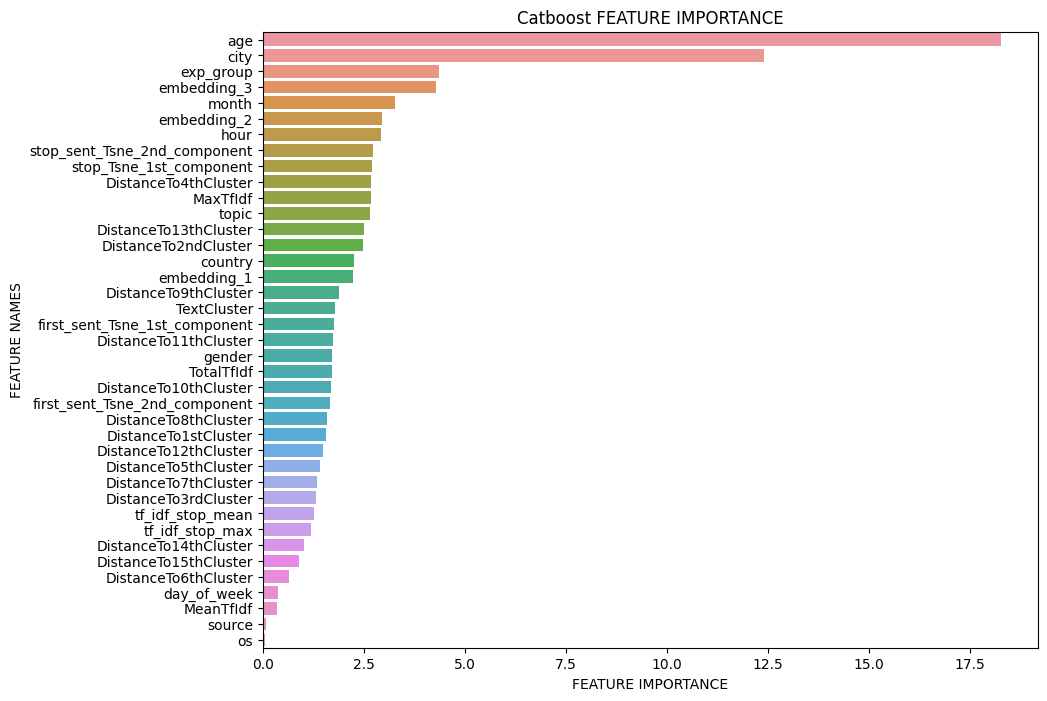

In [56]:
### Из любопытства посмотрим на feature_importance

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(importance, names, model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data = {'feature_names':feature_names, 'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(f'{model_type} FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(model.feature_importances_, X.columns, 'Catboost')

In [ ]:
# Сохраним модель

# catboost.save_model('control_catboost_model', format="cbm")